In [53]:
import json
import os

import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction, SentenceTransformerEmbeddingFunction
from dotenv import load_dotenv
import tiktoken
import torch

#from src.SentenceTransformerEmbeddingFunction import SentenceTransformerEmbeddingFunction

load_dotenv()

True

## Prepare data embeddings
### Step 1 : Initialize a chromaDB

In [54]:
#model_name = "camembert-base"
#model_name = "dangvantuan/sentence-camembert-base"
model_name = "text-embedding-ada-002"

match model_name:
    case "text-embedding-ada-002":
        OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")
        emb_func = OpenAIEmbeddingFunction(
                        api_key=OPENAI_API_KEY,
                        model_name="text-embedding-ada-002"
                    )

    case other:
        emb_func = SentenceTransformerEmbeddingFunction(
            model_name=model_name,
            device="cuda" if torch.cuda.is_available() else "cpu")


chroma_client = chromadb.PersistentClient(path=os.path.join("./ChromaDB", model_name))

### Step 2 : Add chunked documents to chroma

In [55]:
# create collection using folder's name
SOURCE_FOLDER = "./data/chunked-pages-v1"

collection = chroma_client.get_or_create_collection(
    os.path.basename(SOURCE_FOLDER),
    metadata={"hnsw:space": "cosine"},
    embedding_function=emb_func)

In [56]:
# if needed delete a collection
#chroma_client.delete_collection(os.path.basename(SOURCE_FOLDER))

In [57]:
# read the files
file_list = os.listdir(SOURCE_FOLDER)

def read_file(file):
    with open(os.path.join(SOURCE_FOLDER, file), "r") as f:
        return json.load(f)

data = [read_file(f) | {"file": f} for f in file_list]
data[0]

{'source_file': 'ladrome-page-10511.json',
 'chunk_id': 0,
 'text': 'Un peu d’histoire\nSituée à mi-chemin entre l’Europe du nord et du sud, à la croisée des vallées du Rhône et de l’Isère, le département de la Drôme a toujours été une terre de passage, de brassage culturel et économique. La rivière Drôme, qui la transperce d’est en ouest, lui a donné son nom. Ses limites administratives ont été fixées en 1790 et en ont fait un département trait d’union entre Dauphiné et Provence. Rivière La Drôme – Crest © Francis Rey Terre d’asile pour les convertis à la Réforme, puis pour les Arméniens survivants du génocide de 1915, la Drôme s’engagea avec bravoure dans la Résistance contre l’occupant nazi. Le massif du Vercors garde la trace du martyre des maquisards et de la population civile perpétré lors des massacres de juillet 1944. La dernière moitié du 20esiècle a vu la Drôme développer ses infrastructures (autoroutes, gare TGV, aéroport) la rapprochant en temps et distance des métropoles f

In [58]:
# Get an estimate of the total number of token (for cost estimation)
tokeniser = tiktoken.get_encoding("cl100k_base")

n_tokens = sum([len(tokeniser.encode(d["text"])) for d in data])
print("Amount of tokens :", n_tokens)
cost = round(n_tokens/1000*0.0001, 2)
print("Cost using ADAv2 : ", cost, "$")
if cost > 1:
    print("WARNING, BEWARE OF THE COST")

Amount of tokens : 112708
Cost using ADAv2 :  0.01 $


In [59]:
# Build lists to add to chroma
def truncate_text(text, max_tokens_length=8192):
    encoded_text = tokeniser.encode(text)
    return tokeniser.decode(encoded_text[:max_tokens_length])

documents = [truncate_text(d["text"]) for d in data]
metadatas = [{k:v for k,v in d.items() if k in ["chunk_id", "source_file"]} for d in data]
ids = [d["file"].replace(".json", "").replace("ladrome-page-", "") for d in data]

collection.add(
    documents=documents,
    metadatas=metadatas,
    ids=ids,
)

Add of existing embedding ID: 10511_0
Add of existing embedding ID: 10516_0
Add of existing embedding ID: 10516_1
Add of existing embedding ID: 10516_2
Add of existing embedding ID: 10516_3
Add of existing embedding ID: 10516_4
Add of existing embedding ID: 10520_0
Add of existing embedding ID: 10520_1
Add of existing embedding ID: 10520_2
Add of existing embedding ID: 10520_3
Add of existing embedding ID: 10520_4
Add of existing embedding ID: 10520_5
Add of existing embedding ID: 10522_0
Add of existing embedding ID: 10524_0
Add of existing embedding ID: 10526_0
Add of existing embedding ID: 10533_0
Add of existing embedding ID: 10537_0
Add of existing embedding ID: 10542_0
Add of existing embedding ID: 10542_1
Add of existing embedding ID: 10565_0
Add of existing embedding ID: 10565_1
Add of existing embedding ID: 10565_2
Add of existing embedding ID: 10565_3
Add of existing embedding ID: 10565_4
Add of existing embedding ID: 10692_0
Add of existing embedding ID: 10694_0
Add of exist

### Step 3 : add old version of chunks in another collection

In [60]:
# create collection using folder's name
SOURCE_FOLDER = "./data/ladrome-pages-json-v1-Markdown"

collection = chroma_client.get_or_create_collection(
    os.path.basename(SOURCE_FOLDER),
    metadata={"hnsw:space": "cosine"},
    embedding_function=emb_func)


In [61]:
# Delete collection if needed
# chroma_client.delete_collection(os.path.basename(SOURCE_FOLDER))

In [62]:
# read the files
file_list = os.listdir(SOURCE_FOLDER)

def read_file(file):
    with open(os.path.join(SOURCE_FOLDER, file), "r") as f:
        return json.load(f)

data = [read_file(f) | {"file": f} for f in file_list]
data[0]

{'@context': 'https://wikit.ai',
 '@type': 'Document',
 'identifier': 'ladrome:page:10511',
 'name': 'un-peu-dhistoire',
 'title': 'Un peu d’histoire',
 'source': 'La Drôme.fr',
 'url': 'https://www.ladrome.fr/mon-departement/la-drome/un-peu-dhistoire/',
 'dateCreated': '2019-01-07T16:11:49',
 'dateModified': '2023-09-20T10:49:08',
 'fileFormat': 'text/markdown',
 'hasPart': [{'@type': 'DocumentChunk',
   'title': 'Un peu d’histoire',
   'text': 'Un peu d’histoire\n\nSituée à mi-chemin entre l’Europe du nord et du sud, à la croisée des vallées du Rhône et de l’Isère, le département de la Drôme a toujours été une terre de passage, de brassage culturel et économique.\n\nLa rivière Drôme, qui la transperce d’est en ouest, lui a donné son nom. Ses limites administratives ont été fixées en 1790 et en ont fait un département trait d’union entre Dauphiné et Provence.\n\n[![](https://www.ladrome.fr/wp-content/uploads/2023/09/riviere-drome-crest-rey-003.jpg)](https://www.ladrome.fr/wp-content/u

In [63]:
# Get an estimate of the total number of token (for cost estimation)
tokeniser = tiktoken.get_encoding("cl100k_base")

n_tokens = sum([len(tokeniser.encode(d["hasPart"][0]["text"])) for d in data])
print("Amount of tokens :", n_tokens)
cost = round(n_tokens/1000*0.0001, 2)
print("Cost using ADAv2 : ", cost, "$")
if cost > 1:
    print("WARNING, BEWARE OF THE COST")

Amount of tokens : 109706
Cost using ADAv2 :  0.01 $


In [64]:
def truncate_text(text, max_tokens_length=8192):
    encoded_text = tokeniser.encode(text)
    return tokeniser.decode(encoded_text[:max_tokens_length])

# Build lists to add to chroma
documents = [truncate_text(d["hasPart"][0]["text"]) for d in data]
metadatas = [{"source_file":d["file"]} for d in data]
ids = [d["file"].replace(".json", "").replace("ladrome-page-", "") for d in data]

collection.add(
    documents=documents,
    metadatas=metadatas,
    ids=ids,
)

Add of existing embedding ID: 10511
Add of existing embedding ID: 10513
Add of existing embedding ID: 10516
Add of existing embedding ID: 10520
Add of existing embedding ID: 10522
Add of existing embedding ID: 10524
Add of existing embedding ID: 10526
Add of existing embedding ID: 10533
Add of existing embedding ID: 10537
Add of existing embedding ID: 10542
Add of existing embedding ID: 10565
Add of existing embedding ID: 10692
Add of existing embedding ID: 10694
Add of existing embedding ID: 10696
Add of existing embedding ID: 10698
Add of existing embedding ID: 10700
Add of existing embedding ID: 10708
Add of existing embedding ID: 10710
Add of existing embedding ID: 10712
Add of existing embedding ID: 10714
Add of existing embedding ID: 10718
Add of existing embedding ID: 10720
Add of existing embedding ID: 10722
Add of existing embedding ID: 10728
Add of existing embedding ID: 10730
Add of existing embedding ID: 10732
Add of existing embedding ID: 10734
Add of existing embedding ID

## Try out the DB

In [90]:
# Choose a collection name
collection_name = "chunked-pages-v1"
#collection_name = "ladrome-pages-json-v1-Markdown"
# Choose a query
query = "Oû puis-je faire un randonnée ?"
# choose the number of results
n_results = 10
# choose whether or not results are printed
print_results = True

collection = chroma_client.get_or_create_collection(
    collection_name,
    metadata={"hnsw:space": "cosine"},
    embedding_function=emb_func)

result = collection.query(
    query_texts=query,
    n_results=n_results,
)

if print_results:
    for rd, id in zip(result["documents"][0], result["ids"][0]):
        print(f"---------{id}---------")
        print(rd)

---------11016_0---------
Les bons plans sports nature
Les sports nature font partie de l’ADN de la Drôme ! Randonnée pédestre, VTT, course d’orientation, escalade, trail, canoë, spéléo, parapente… presque tous les sports de nature peuvent se pratiquer dans la Drôme. Le Département œuvre au quotidien, en partenariat avec de nombreux acteurs, pour aménager des sites de pratique, les entretenir et concilier les usages. La Drôme compte aujourd’hui 
- environ 6 000 km de sentiers de randonnée (pédestre, équestre, VTT) 
- 500 km d’itinéraires d’activités aquatiques (canoë kayak) 
- 7 stations hiver/été 
- 5 via ferrata 
- une vingtaine d’Espaces Sports Orientation 
- une cinquantaine de sites de vol libre 
- plus d’une centaine de sites d’escalade 
- une centaine de cavités de spéléologie… Retrouvez tous les parcours et sentiers sur l’application mobile La Drôme et laissez-vous guider ! Accès à l’extranet sport nature
Pour plus d'informations:
- Accès à l’extranet sport nature: https://coll

## Test with labeled dataset
### Step 1 : read dataset

In [66]:
import pandas as pd

In [67]:
dataset = pd.read_csv("./data/d26_queries.csv", sep=";")
dataset.head()

,queries,label
0,Combien de productions ont déjà bénéficié du f...,573222_1
1,Je voudrais bénéficier de l'accueil familial. ...,13929_0
2,Quels sont les horaires du musée départemental...,10958_2
3,Quels sont les résultats du site en terme d'ac...,479533_2
4,Qu'est ce que la cartoucherie ?,10516_3


### Step 2 : Test with new chunks

In [68]:
# Choose a collection name
collection_name = "chunked-pages-v1"

# Query the DB with all queries
queries = dataset["queries"].tolist()
collection = chroma_client.get_or_create_collection(
    collection_name,
    metadata={"hnsw:space": "cosine"},
    embedding_function=emb_func)
n_results = collection.count() # get the results on the entire DB

print(f"The collection has {collection.count()} documents")

result = collection.query(
    query_texts=queries,
    n_results=n_results,
)

The collection has 356 documents


In [69]:
result_df = pd.DataFrame.from_dict(result)
result_df.drop(["embeddings", "uris", "data"], inplace=True, axis=1)
result_df["query"] = queries
result_df["label"] = dataset["label"].tolist()
result_df.head(3)

,ids,distances,metadatas,documents,query,label
0,"[573222_1, 10516_3, 573222_0, 558934_1, 558934...","[0.12491986622756013, 0.16017073392868042, 0.1...","[{'chunk_id': 1, 'source_file': 'ladrome-page-...",[Le cinéma d’animation dans la Drôme\nLe Fonds...,Combien de productions ont déjà bénéficié du f...,573222_1
1,"[10909_0, 13929_0, 10765_1, 504967_3, 13927_0,...","[0.16223925352096558, 0.16284793615341187, 0.1...","[{'chunk_id': 0, 'source_file': 'ladrome-page-...",[L’accueil familial pour les personnes en situ...,Je voudrais bénéficier de l'accueil familial. ...,13929_0
2,"[10958_2, 10958_1, 10958_5, 10958_3, 10958_6, ...","[0.07024234533309937, 0.10183370113372803, 0.1...","[{'chunk_id': 2, 'source_file': 'ladrome-page-...",[Le musée départemental de la Résistance du Ve...,Quels sont les horaires du musée départemental...,10958_2


In [70]:
# Get the position of the labeled document in the results using metadatas
# best if rank closer to 0
def get_label_position(row):
    # get the source files, which are ordered by distance
    return row["ids"].index(row["label"])


result_df["label_rank"] = result_df.apply(get_label_position, axis=1)
result_df = result_df.sort_values(by="label_rank").reset_index()
# show the result
result_df[["query", "label_rank", "label"]].head(50)

,query,label_rank,label
0,Combien de productions ont déjà bénéficié du f...,0,573222_1
1,Quelles sont les actions en faveur de l'utilis...,0,10537_0
2,on voudrait adopter un enfant. Qui doit-on con...,0,10759_0
3,Je voudrais savoir si je suis éligible à la fi...,0,504961_0
4,Quelle est l'adresse de la MDA de Valence ?,0,10793_1
5,Où trouver les annonces marchés publics du Dép...,0,95161_0
6,Je voudrais trouver une association sportive d...,0,11012_0
7,Qu'est-ce-qu'un ENS ?,0,10989_0
8,Par quelles villes va passer la flamme olympiq...,0,567239_1
9,J'aimerai avec des infos sur le sentier du karst,0,61497_0


In [71]:
# analyze result of the specific query id
query_id = 49 # the index of the dataframe above
topk = 10

record = result_df.iloc[query_id]
print(record["query"])
for i, (id, r) in enumerate(zip(record["ids"][:topk], record["documents"][:topk])):
    print(f"Chunk n°{i}--------------{id}------------------")
    print(r)

J'ai des questions sur les cookies. J'aimerai contacter quelqu'un
Chunk n°0--------------581681_7------------------
Politique de cookies
Vous avez chargé la politique de cookies sans le support de javascript.Sur AMP, vous pouvez utiliser l’onglet de gestion du consentement en bas de la page.8. Activer/désactiver et supprimer les cookies
Vous pouvez utiliser votre navigateur internet pour supprimer automatiquement ou manuellement les cookies. Vous pouvez également spécifier que certains cookies ne peuvent pas être placés. Une autre option consiste à modifier les réglages de votre navigateur Internet afin que vous receviez un message à chaque fois qu’un cookie est placé. Pour plus d’informations sur ces options, reportez-vous aux instructions de la section Aide de votre navigateur. Veuillez noter que notre site web peut ne pas marcher correctement si tous les cookies sont désactivés. Si vous supprimez les cookies dans votre navigateur, ils seront de nouveau placés après votre consentemen

In [72]:
# Store df in new variable for comparison later
result_new_chunks = result_df.copy()

### Step 3: Test with old chunks

In [73]:
# Choose a collection name
collection_name = "ladrome-pages-json-v1-Markdown"

# Query the DB with all queries
queries = dataset["queries"].tolist()
collection = chroma_client.get_or_create_collection(
    collection_name, metadata={"hnsw:space": "cosine"},
    embedding_function=emb_func)

n_results = collection.count() # get the results on the entire DB

print(f"The collection has {collection.count()} documents")

result = collection.query(
    query_texts=queries,
    n_results=n_results,
)

The collection has 190 documents


In [74]:
result_df = pd.DataFrame.from_dict(result)
result_df.drop(["embeddings", "uris", "data"], inplace=True, axis=1)
result_df["query"] = queries
result_df["label"] = dataset["label"].tolist()
result_df.head(3)

,ids,distances,metadatas,documents,query,label
0,"[573222, 558934, 558941, 10738, 10962, 10745, ...","[0.16921969093344302, 0.1936017632628877, 0.19...","[{'source_file': 'ladrome-page-573222.json'}, ...",[Le cinéma d’animation dans la Drôme\n\n### Un...,Combien de productions ont déjà bénéficié du f...,573222_1
1,"[13929, 10909, 10866, 10905, 13927, 41417, 107...","[0.15755938120668345, 0.15902209281921387, 0.1...","[{'source_file': 'ladrome-page-13929.json'}, {...",[L’accueil familial pour les personnes âgées\n...,Je voudrais bénéficier de l'accueil familial. ...,13929_0
2,"[10958, 10944, 11020, 10970, 10966, 574603, 54...","[0.10304427146911621, 0.18001419305801392, 0.1...","[{'source_file': 'ladrome-page-10958.json'}, {...",[Le musée départemental de la Résistance du Ve...,Quels sont les horaires du musée départemental...,10958_2


In [75]:
# Get the position of the labeled document in the results using metadatas
# best if rank closer to 0
def get_label_position(row):
    # get the source files, which are ordered by distance
    return row["ids"].index(row["label"].split("_")[0])


result_df["label_rank"] = result_df.apply(get_label_position, axis=1)
result_df = result_df.sort_values(by="label_rank").reset_index()
# show the result
result_df[["query", "label_rank", "label"]].head(50)

,query,label_rank,label
0,Combien de productions ont déjà bénéficié du f...,0,573222_1
1,Y aura-t-il des options siences dans le collèg...,0,547344_2
2,Quelles sont les actions en faveur de l'utilis...,0,10537_0
3,on voudrait adopter un enfant. Qui doit-on con...,0,10759_0
4,Je voudrais savoir si je suis éligible à la fi...,0,504961_0
5,Quelle est l'adresse de la MDA de Valence ?,0,10793_1
6,Où trouver les annonces marchés publics du Dép...,0,95161_0
7,Je voudrais trouver une association sportive d...,0,11012_0
8,Quelles sont les règles du buget participatif ?,0,547395_5
9,Qu'est-ce-qu'un ENS ?,0,10989_0


In [76]:
# analyze result of the specific query id
query_id = 35 # the index of the dataframe above
topk = 10

record = result_df.iloc[query_id]
print(record["query"])
for i, r in zip(record["ids"][:topk], record["documents"][:topk]):
    print(f"----------------{i}------------------")
    print(r)

J'aimerai avec des infos sur le sentier du karst
----------------11020------------------
Les stations de la Drôme


----------------61497------------------
Alpage de Font d’Urle (Vercors)

Grandiose, spectaculaire, sauvage…  
Tels sont les mots qui viennent à l’esprit en évoquant l’alpage de Font d’Urle, ce plateau de 618 hectares propriété du Département de la Drôme depuis 1953.

C’est **un site géologique** passionnant, où se rencontrent des formes spectaculaires liées à l’érosion du calcaire par l’eau, appelées « karst » : roche sculptée en surface, crevasses, puits naturels, grottes, rivières souterraines…

[![](https://www.ladrome.fr/wp-content/uploads/2020/02/ecogarde-matras-004.jpg)](https://www.ladrome.fr/wp-content/uploads/2020/02/ecogarde-matras-004.jpg)

[![](https://www.ladrome.fr/wp-content/uploads/2020/02/font-durle-matras-006.jpg)](https://www.ladrome.fr/wp-content/uploads/2020/02/font-durle-matras-006.jpg)

[![](https://www.ladrome.fr/wp-content/uploads/2020/02/font-dur

In [77]:
# Store result in new variable for comparison later
result_old_chunks = result_df.copy()

### Step 4 : Compare !
#### Position of the relevant document in the retrieved documents

In [78]:
new_collection_size = len(result_new_chunks.iloc[0]["ids"])
print(f"Collection size : {new_collection_size}")
result_new_chunks.head(2)

Collection size : 356


,index,ids,distances,metadatas,documents,query,label,label_rank
0,0,"[573222_1, 10516_3, 573222_0, 558934_1, 558934...","[0.12491986622756013, 0.16017073392868042, 0.1...","[{'chunk_id': 1, 'source_file': 'ladrome-page-...",[Le cinéma d’animation dans la Drôme\nLe Fonds...,Combien de productions ont déjà bénéficié du f...,573222_1,0
1,24,"[10537_0, 555844_1, 10520_3, 555844_2, 555850_...","[0.1512928009033203, 0.1571102738380432, 0.163...","[{'chunk_id': 0, 'source_file': 'ladrome-page-...","[A vélo\nVéritable projet de territoire, le Dé...",Quelles sont les actions en faveur de l'utilis...,10537_0,0


In [79]:
old_collection_size = len(result_old_chunks.iloc[0]["ids"])
print(f"Collection size : {old_collection_size}")
result_old_chunks.head(2)

Collection size : 190


,index,ids,distances,metadatas,documents,query,label,label_rank
0,0,"[573222, 558934, 558941, 10738, 10962, 10745, ...","[0.16921969093344302, 0.1936017632628877, 0.19...","[{'source_file': 'ladrome-page-573222.json'}, ...",[Le cinéma d’animation dans la Drôme\n\n### Un...,Combien de productions ont déjà bénéficié du f...,573222_1,0
1,23,"[547344, 43852, 549293, 10732, 10738, 10728, 1...","[0.14923669448309462, 0.15043755589421803, 0.1...","[{'source_file': 'ladrome-page-547344.json'}, ...",[FAQ – futur collège Mercurol-Veaunes\n\nRetro...,Y aura-t-il des options siences dans le collèg...,547344_2,0


In [80]:
def get_label_rank_percentage(result_df, collection_size):
    """Get the cumulative percentage of the rank of the relevant document

    Args:
        result_df (pd.DataFrame): the results of the retriever
        collection_size (int): the size of the collection of documents
    """
    chunk_rank_counts = result_df["label_rank"].value_counts().sort_index()
    missing_indexes = [i for i in range(collection_size) if i not in chunk_rank_counts.index]
    chunk_rank_counts = pd.concat(
        [chunk_rank_counts,
        pd.DataFrame([0 for _ in range(len(missing_indexes))],
        index=missing_indexes)]).sort_index()
    chunk_rank_percent = chunk_rank_counts.cumsum().div(len(result_df)).round(3)

    return chunk_rank_percent

In [81]:
new_chunk_rank_percent = get_label_rank_percentage(result_new_chunks, new_collection_size).rename(columns={0: "New chunks"})
old_chunk_rank_percent = get_label_rank_percentage(result_old_chunks, old_collection_size).rename(columns={0: "Old chunks"})

<Axes: >

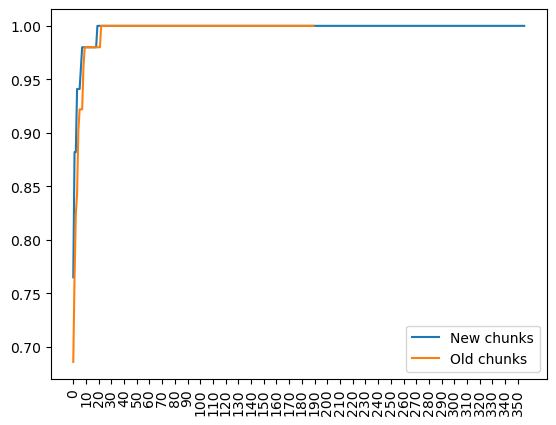

In [82]:
# Plot the cumulative percentage of retrieval position
df_to_plot = pd.concat([new_chunk_rank_percent, old_chunk_rank_percent], axis=1)
df_to_plot.plot(xticks=[i for i in df_to_plot.index if i % 10 == 0], rot=90)

As we can see, the new chunking method performs better : the position at which the relevant document is retrieved is closer to 0, despite having a greater amount of documents in the collection !
WARNING : As the queries were built using the new chunks, there might be bias to keep in mind !

<Axes: >

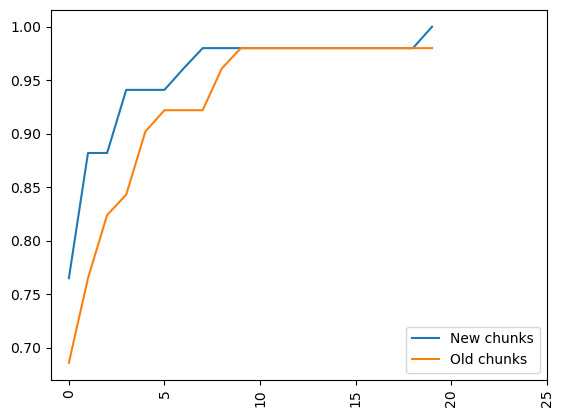

In [83]:
# Zoom on the begining of the curve
df_to_plot[:20].plot(xticks=[i for i in df_to_plot.index[:30] if i % 5 == 0], rot=90)

If we zoom in, we actually see that the old chunks perform better in terms of top 1 : in 50% of case, the relevant document is retrieved at index 0. Howerver, the new chunks perfrom better if we llok at top 5 or top 10.

#### Length of the context depending on amount of chunks selected

In [84]:
import tiktoken

def get_topks_relevance(result_df, topks=[1,5,10,20]):

    def get_context_length(docs, n_docs):
        return sum([len(tokenizer.encode(doc)) for doc in docs[:n_docs]])

    tokenizer = tiktoken.get_encoding("cl100k_base")
    records = {}
    for topk in topks:
        relevant_is_here = round(len(result_df[result_df["label_rank"] < topk]) / len(result_df) * 100, 1)
        mean_length_of_context = result_df["documents"].apply(get_context_length, args=[topk]).mean().round()
        median_length_of_context = result_df["documents"].apply(get_context_length, args=[topk]).median().round()

        records[topk] = {"relevant_isin_ctx%":relevant_is_here, "mean_token_count_in_ctx": mean_length_of_context, "median_token_count_in_ctx":median_length_of_context}

    return pd.DataFrame.from_records(records)

In [85]:
print("Values of context length for topk for NEW chunks")
get_topks_relevance(result_new_chunks)

Values of context length for topk for NEW chunks


,1,5,10,20
relevant_isin_ctx%,76.5,94.1,98.0,100.0
mean_token_count_in_ctx,303.0,1244.0,2666.0,5141.0
median_token_count_in_ctx,205.0,1056.0,2412.0,4714.0


In [86]:
print("Values of context length for topk for OLD chunks")
get_topks_relevance(result_old_chunks, topks=[1, 5, 10, 20])

Values of context length for topk for OLD chunks


,1,5,10,20
relevant_isin_ctx%,68.6,90.2,98.0,98.0
mean_token_count_in_ctx,852.0,2315.0,4822.0,10181.0
median_token_count_in_ctx,484.0,1707.0,3938.0,9678.0


##### Interpretation
- Relevant_is_ctx% = How many times the relevant document is in the context, if we keep only the top k documents (as a percentage among the queries of the dataset). -> by increasing the amount of documents we keep, we increase the amount the frequency at which the relevant document is in the context

- mean_token_count_in_ctx = The average amount tokens in the context. As we increase the k amount of documents we keep, the length of the context increases. This is not what we want, as higher context length means more superfluous information for the LLM, and more money spent for querying the LLM !

- median_token_count_in_ctx = same as above, but median instead of mean


##### Conclusion
It seems that the new chunking method present several advantages over the old method:
- It has better retrieval rates
- it allows for smaller chunks, resulting in smaller context : on average the token amount in the context is divided by 2. Thus we can hope an increase in performance in terms of response generation by the LLM
- the retrieval performance of the new chunking method is better, even though the amount of documents is multiplied by 2

##### Disclaimer
- Keep in mind that the queries of the test dataset where formulated by using the new chunks. Thus the dataset may be biased toward the new chunks method
- Some problems needs to be solved : for example with the new chunking method, the text of a part that is outside its subpart is discarded (e.g. the introductions of part) resulting in a loss of information